# Modelo de Ising 2 Dimensões
### Rede Quadrada/Retângular com sitios centrais com 4, bordas com 3 e vertice com 2 vizinhos.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

Quantidade de Linhas e colunas da rede, Quantidade de sitios := N = LC

In [14]:
#Numero de sitios := NxN
N = 10

### Gera uma rede de spins baseada no sorteio random.random

In [15]:
init_random = np.random.random((N, N))
rede_N = np.zeros((N, N))
rede_N[init_random>=0.50] = 1
rede_N[init_random<0.50] = -1

rede_N

array([[-1., -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1.],
       [ 1., -1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.],
       [ 1.,  1., -1., -1.,  1., -1., -1., -1., -1.,  1.],
       [ 1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1.],
       [-1., -1.,  1., -1.,  1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1.],
       [-1., -1., -1.,  1., -1.,  1., -1., -1.,  1., -1.],
       [ 1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.],
       [ 1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.],
       [-1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.]])

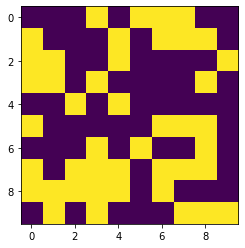

In [27]:
plt.imshow(rede_N)

### Define a Energia do sistema, é calcula a interação dos vizinhos.
### $\frac{Energia}{J} = -\sum_{ij}s_is_j$.

Falta a energia do campo $h_is_i$

In [18]:
def Energia(rede):
    # kern -> faz o somatorio dos vizinhos
    kern = generate_binary_structure(2, 1) #pesquisar como funciona
    kern[1][1] = False
    arr = -rede * convolve(rede, kern, mode='constant', cval=0)
    return arr.sum()

In [19]:
kern = generate_binary_structure(2, 1)
kern[1][1] = False

In [21]:
Energia(rede_N)

4.0

In [22]:
A = convolve(rede_N, kern, mode='constant', cval=0)

# Escolhe um spin aleatorio gira, calcula a diferença de energia devido a esta nova configurarção dada por $s_i \rightarrow -s_i$

In [23]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True) 
def metropolis(spin_arr, times, BJ, energia):
    spin_arr = spin_arr.copy()
    n_spins = np.zeros(times-1)
    n_energia = np.zeros(times-1)
    for t in range(0, times-1):
        # escolhe um spin aleatorio e gira
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #spin inicial
        spin_f = spin_i*-1 #spin flipado
        
        # Calcula a variação da energia
        E_i = 0
        E_f = 0
        #considerar as bordas
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<L-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<C-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        # Para manter ou nao a mudança
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energia += dE
            #rede_N
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energia += dE
        n_spins[t] = spin_arr.sum()
        n_energia[t] = energia 
    return n_spins, n_energia


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mNameError: name 'L' is not defined[0m

In [24]:
spins, energia = metropolis(rede_N, 500, 100, Energia(rede_N))

NameError: name 'metropolis' is not defined

NameError: name 'spins' is not defined

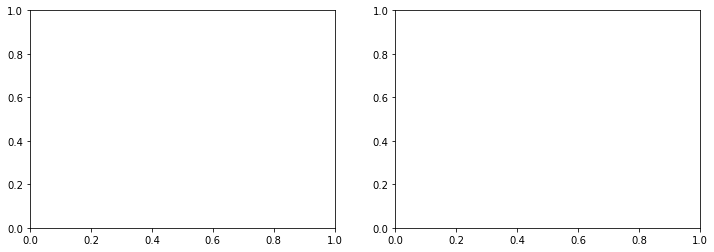

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energia)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energ    $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$x', y=1.07, size=18)
plt.show()

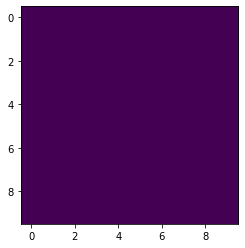

In [26]:
plt.imshow(np.zeros((N,N)))